# Tarea Semanal 7: Primeras nociones de estimación espectral: Ancho de banda de señales.
## Magdalena Noé
En esta tarea se analizaran 3 señales:
- Electrocardiograma (ECG): Registrado durante una prueba de esfuerzo.
- Pletismografía (PPG). Registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
- Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.

El analisis a realizar en dichas señales sera una estimación de ancho de banda y de la densidad espectral de potencia (PSD) mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

Hacia el final tambien analizamos otro set de señales; 3 audios de llamados de ballena austral y 2 sismogramas registrados en Chile 2025 y Argentina 2023.

### Librerías

In [93]:
import matplotlib.pyplot as plt
from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()
import numpy as np
from scipy import signal as sig
import scipy.io as sio # Para leer los audios (.wav)
from obspy import read # Para leer los sismogramas (.sac)

## Primera lectura de las señales

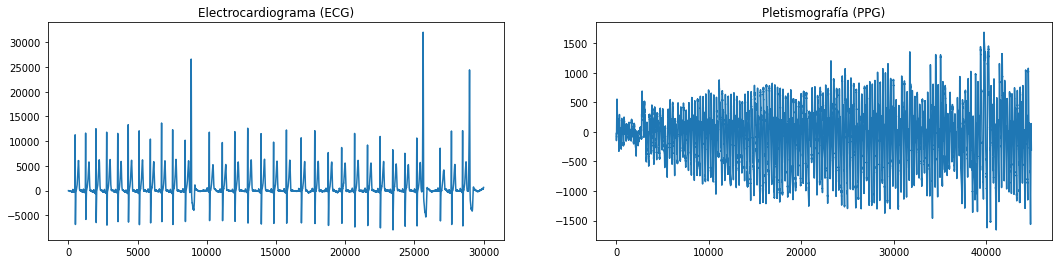

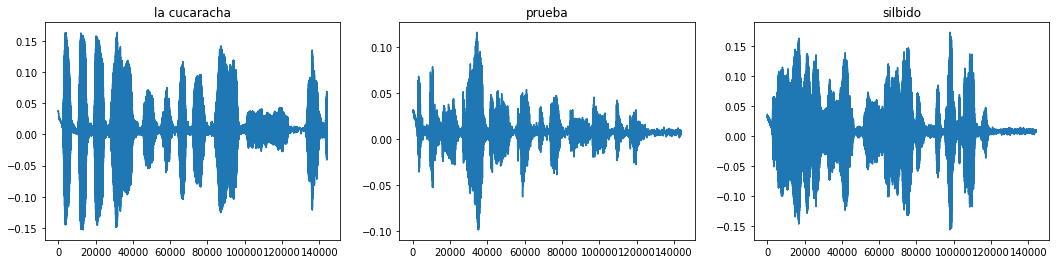

In [94]:
ecg_one_lead = np.load('signals_ts7\ecg_sin_ruido.npy')
fs_ecg = 1000 # Hz

ppg = np.load('signals_ts7\ppg_sin_ruido.npy')
fs_ppg = 400 # Hz

plt.figure(figsize=(18, 4))
plt.subplot(1,2,1); plt.plot(ecg_one_lead); plt.title("Electrocardiograma (ECG)")
plt.subplot(1,2,2); plt.plot(ppg); plt.title("Pletismografía (PPG)")
plt.show()

fs_audio_A, wav_data_A = sio.wavfile.read('signals_ts7\la cucaracha.wav')
fs_audio_B, wav_data_B = sio.wavfile.read('signals_ts7\prueba psd.wav')
fs_audio_C, wav_data_C = sio.wavfile.read('signals_ts7\silbido.wav')

arr_fs_audios = [fs_audio_A, fs_audio_B, fs_audio_C]
arr_wav_data = [wav_data_A, wav_data_B, wav_data_C]

plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(wav_data_A); plt.title("la cucaracha")
plt.subplot(1,3,2); plt.plot(wav_data_B); plt.title("prueba")
plt.subplot(1,3,3); plt.plot(wav_data_C); plt.title("silbido")
plt.show()

## Análisis de las señales
### Densidad espectral de potencia (PSD)

Para obtener la PSD se utiliza la funcion periodogram.

- periodogram() Estimate power spectral density using a periodogram.
    - x: array_like
    Time series of measurement values
    - fs: float, optional
    Sampling frequency of the x time series. Defaults to 1.0.

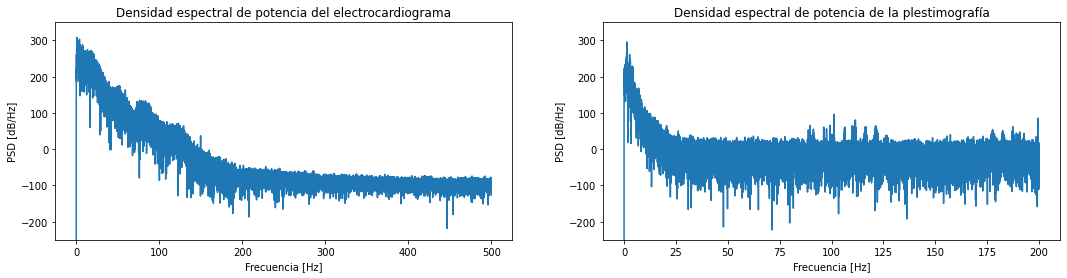

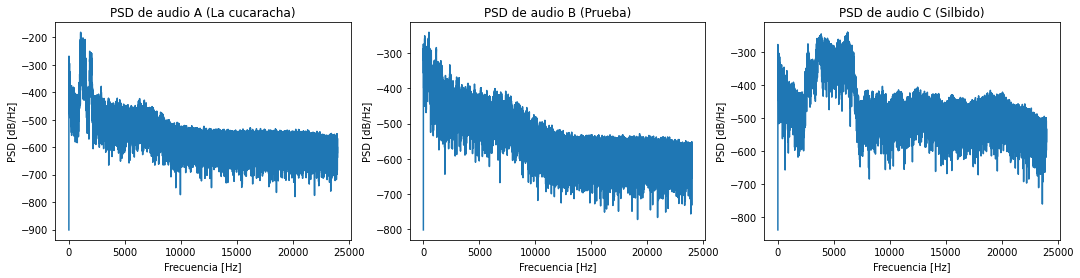

In [95]:
ff_ecg, psd_ecg = sig.periodogram(ecg_one_lead, fs=fs_ecg)
psd_ecg_dB = 20*np.log(psd_ecg)

ff_ppg, psd_ppg = sig.periodogram(ppg, fs=fs_ppg)
psd_ppg_dB = 20*np.log(psd_ppg)

plt.figure(figsize=(18, 4))
plt.subplot(1,2,1); plt.plot(ff_ecg, psd_ecg_dB); plt.ylim(-250,350)
plt.title("Densidad espectral de potencia del electrocardiograma")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,2,2); plt.plot(ff_ppg, psd_ppg_dB); plt.ylim(-250,350)
plt.title("Densidad espectral de potencia de la plestimografía")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.show()

ff_wav_A, psd_wav_A = sig.periodogram(wav_data_A, fs=fs_audio_A); psd_wav_A_dB = 20*np.log(psd_wav_A)
ff_wav_B, psd_wav_B = sig.periodogram(wav_data_B, fs=fs_audio_B); psd_wav_B_dB = 20*np.log(psd_wav_B)
ff_wav_C, psd_wav_C = sig.periodogram(wav_data_C, fs=fs_audio_C); psd_wav_C_dB = 20*np.log(psd_wav_C)

plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(ff_wav_A, psd_wav_A_dB)
plt.title("PSD de audio A (La cucaracha)"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,3,2); plt.plot(ff_wav_B, psd_wav_B_dB)
plt.title("PSD de audio B (Prueba)"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,3,3); plt.plot(ff_wav_C, psd_wav_C_dB)
plt.title("PSD de audio C (Silbido)"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.show()

## Estimación del ancho de banda

Para estimar el ancho de banda un buen procedimiento es buscar el rango de frecuencias que contienen una dada fraccion de la energia espectral total, por ejemplo el 90%. Ahora el metodo utilizado para buscar este rango de frecuencias dependera de la señal. Hay que tener en cuenta los PSDs graficados. 

En el caso del electro y plestimo esta claro que son señales cuya energia se concentra en las frecuencias bajas, se aplicará un pasabajos. Por lo que un buen metodo para determinar el ancho de banda es un barriendo las frecuencias desde la izquierda hasta obtener un 90% de la energia espectral total.

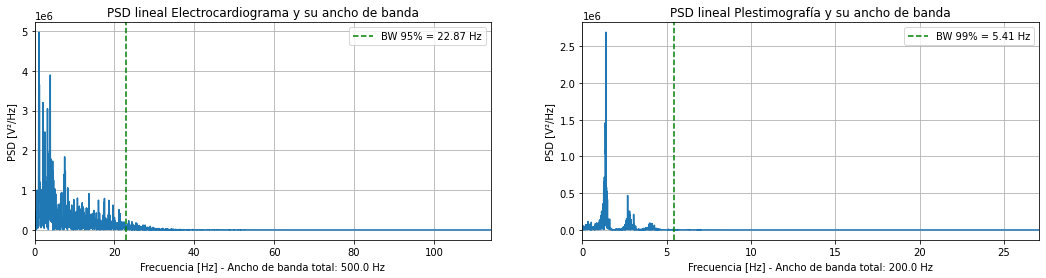

In [96]:
def obtener_bw_pasabajos(psd,ff,porcentaje):
    pot_bw = 0; pot_tot = 0
    bw = 1; bw_anterior = 0 # en posiciones de arr
    df = ff[1] - ff[0]
    pot_tot = np.sum(psd)
    bw_tot = len(psd)
    # Nota: la potencia real deberia estar mutiplicada por df
    while pot_bw < (pot_tot * porcentaje) and bw < bw_tot:
        pot_bw += np.sum(psd[bw_anterior:bw])
        bw_anterior = bw
        bw += 1  # avanza df Hz
    
    return bw*df

bw_ecg = obtener_bw_pasabajos(psd_ecg,ff_ecg,0.95)
bw_ppg = obtener_bw_pasabajos(psd_ppg,ff_ppg,0.99)

### GRAFICOS ###

plt.figure(figsize=(18, 4))
plt.subplot(1,2,1); plt.plot(ff_ecg, psd_ecg); plt.xlim(0, bw_ecg*5)
plt.axvline(x=bw_ecg, color='green', linestyle='--', label=f'BW 95% = {bw_ecg:.2f} Hz')
plt.title("PSD lineal Electrocardiograma y su ancho de banda")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_ecg[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,2,2); plt.plot(ff_ppg, psd_ppg); plt.xlim(0, bw_ppg*5)
plt.axvline(x=bw_ppg, color='green', linestyle='--', label=f'BW 99% = {bw_ppg:.2f} Hz')
plt.title("PSD lineal Plestimografía y su ancho de banda")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_ppg[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.show()


Para la señales de audio se observa que presentan picos de energia en frecuencias intermedias, alejadas de 0 Hz, por lo que apunta al uso de un pasa-banda, complejizando el analisis. 

Un buen punto de inicio es el mayor pico de energia, e ir expandiendo la ventana en ambas direcciones.
En este caso particular iremos expandiendo la ventana tal que el nuevo area cubierta por la izquierda debe contener la misma energia que el nuevo area cubierta por la derecha, evitando asi la inclusion de frecuencias de baja potencia en caso de que el pico no se encuentre en el medio del ancho de banda (Como sucedera normalmente).

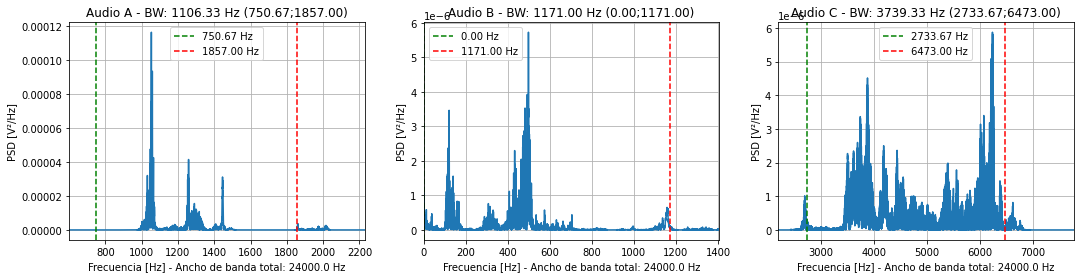

In [97]:
def obtener_bw_pasabanda(psd,ff,porcentaje):
    pot_izq=0;pot_der=0;pot_tot = 0
    origen = np.argmax(psd) # Indice de maxima potencia (lo tomo como punto de partida para el bw)
    ind_izq = origen-1; ind_der = origen+1
    df = ff[1] - ff[0]
    pot_tot = np.sum(psd)
    bw_tot = len(psd)
    
    dt_izq = 0; dt_der = 0
    # Nota: la potencia real deberia estar mutiplicada por df
    while (pot_izq+pot_der) < (pot_tot * porcentaje) and ind_der < bw_tot:
        pot_izq = np.sum(psd[ind_izq:origen])
        pot_der = np.sum(psd[origen:ind_der])

        dt_izq = np.sum(psd[ind_izq:ind_izq+1])
        dt_der = np.sum(psd[ind_der-1:ind_der])
        if(dt_izq > dt_der): # Si hay mas potencia por la derecha, sigo explayando mi bw para la derecha
            ind_izq -= 1
        elif(dt_der > dt_izq): # Si hay mas potencia por la izquierda, sigo explayando mi bw para la izquierda
            ind_der += 1
        else:           # En el caso de que haya igual potencia en ambos lados, aumento mi bw para ambos lados
            ind_der += 1
            ind_izq -= 1
    return (ind_izq)*df, (ind_der)*df

lim_izq_a,lim_der_a = obtener_bw_pasabanda(psd_wav_A,ff_wav_A,0.95)
lim_izq_b,lim_der_b = obtener_bw_pasabanda(psd_wav_B,ff_wav_B,0.95)
lim_izq_c,lim_der_c = obtener_bw_pasabanda(psd_wav_C,ff_wav_C,0.95)

### GRAFICOS ###

plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(ff_wav_A, psd_wav_A); plt.xlim(lim_izq_a*0.8, lim_der_a*1.2)
plt.axvline(x=lim_izq_a, color='green', linestyle='--', label=f'{lim_izq_a:.2f} Hz')
plt.axvline(x=lim_der_a, color='red', linestyle='--', label=f'{lim_der_a:.2f} Hz')
plt.title(f"Audio A - BW: {lim_der_a-lim_izq_a:.2f} Hz ({lim_izq_a:.2f};{lim_der_a:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_A[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,3,2); plt.plot(ff_wav_B, psd_wav_B); plt.xlim(lim_izq_b*0.8, lim_der_b*1.2)
plt.axvline(x=lim_izq_b, color='green', linestyle='--', label=f'{lim_izq_b:.2f} Hz')
plt.axvline(x=lim_der_b, color='red', linestyle='--', label=f'{lim_der_b:.2f} Hz')
plt.title(f"Audio B - BW: {lim_der_b-lim_izq_b:.2f} Hz ({lim_izq_b:.2f};{lim_der_b:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_B[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,3,3); plt.plot(ff_wav_C, psd_wav_C); plt.xlim(lim_izq_c*0.8, lim_der_c*1.2)
plt.axvline(x=lim_izq_c, color='green', linestyle='--', label=f'{lim_izq_c:.2f} Hz')
plt.axvline(x=lim_der_c, color='red', linestyle='--', label=f'{lim_der_c:.2f} Hz')
plt.title(f"Audio C - BW: {lim_der_c-lim_izq_c:.2f} Hz ({lim_izq_c:.2f};{lim_der_c:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_C[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()
plt.show()

## Nuevas señales

3 señales de audio
Llamados de ballena franca austral, tomados entre 1992 y 1997 en el Golfo de San Jose, Argentina
Watkins Marine Mammal Sound Database, Woods Hole Oceanographic Institution and the New Bedford Whaling Museum.
https://cis.whoi.edu/science/B/whalesounds/bestOf.cfm?code=AA3B
https://cis.whoi.edu/science/B/whalesounds/index.cfm
Ya analizamos señales de audio pero me parecia interesante comparar la diferencia en el rango frecuencial.

2 Señales de sismometro tomadas en el norte de Chile y Salta, Argentina, con el sistema EQ-1. 

- Caso Chile: este registro un sismo de magnitud 6.4 el 6 de junio de 2025.
https://geoserver.iris.edu/node/558118
- Caso Argentina: este registro un sismo de magnitud 5.6 el 10 de noviembre de 2023.
https://geoserver.iris.edu/node/526826


https://shop.skolebutik.dk/images/pdf/Next_Seismograph_System.pdf
https://service.iris.edu/fdsnws/dataselect/1/


Vamos a realizar los analisis en cascada, empezando con los llamado de ballena

## Audios: Ballena Austral

In [98]:
# Obtengo datos del archivo .wav
fs_audio_D, wav_data_D = sio.wavfile.read('signals_ts7/7900200T.wav')
fs_audio_E, wav_data_E = sio.wavfile.read('signals_ts7/7900200U.wav')
fs_audio_F, wav_data_F = sio.wavfile.read('signals_ts7/79002007.wav')

# Calculo su PSD con periodogram()
ff_wav_D, psd_wav_D = sig.periodogram(wav_data_D, fs=fs_audio_D); psd_wav_D_dB = 20*np.log(psd_wav_D)
ff_wav_E, psd_wav_E = sig.periodogram(wav_data_E, fs=fs_audio_E); psd_wav_E_dB = 20*np.log(psd_wav_E)
ff_wav_F, psd_wav_F = sig.periodogram(wav_data_F, fs=fs_audio_F); psd_wav_F_dB = 20*np.log(psd_wav_F)

# Estimo un ancho de banda con mi funcion
lim_izq_d,lim_der_d = obtener_bw_pasabanda(psd_wav_D,ff_wav_D,0.90)
lim_izq_e,lim_der_e = obtener_bw_pasabanda(psd_wav_E,ff_wav_E,0.90)
lim_izq_f,lim_der_f = obtener_bw_pasabanda(psd_wav_F,ff_wav_F,0.90)

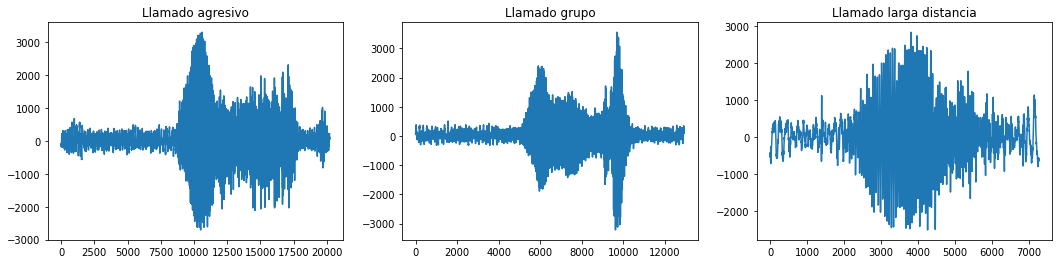

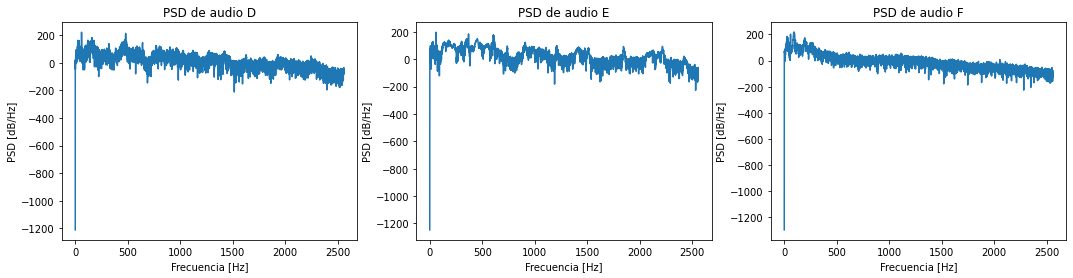

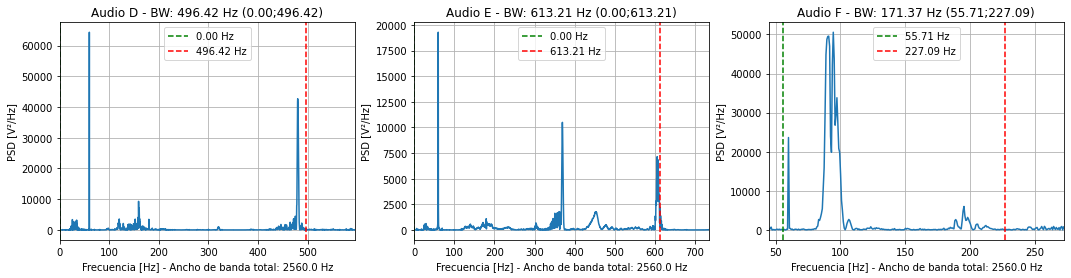

In [99]:
### GRAFICOS ###

##  GRAFICO TEMPORAL ##
plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(wav_data_D); plt.title("Llamado agresivo")
plt.subplot(1,3,2); plt.plot(wav_data_E); plt.title("Llamado grupo")
plt.subplot(1,3,3); plt.plot(wav_data_F); plt.title("Llamado larga distancia")
plt.show()

## DENSIDAD ESPECTRAL DE POTENCIA ##
plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(ff_wav_D, psd_wav_D_dB)
plt.title("PSD de audio D"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,3,2); plt.plot(ff_wav_E, psd_wav_E_dB)
plt.title("PSD de audio E"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,3,3); plt.plot(ff_wav_F, psd_wav_F_dB)
plt.title("PSD de audio F"); plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.show()

## ESTIMACION ANCHO DE BANDA ##
plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.plot(ff_wav_D, psd_wav_D); plt.xlim(lim_izq_d*0.8, lim_der_d*1.2)
plt.axvline(x=lim_izq_d, color='green', linestyle='--', label=f'{lim_izq_d:.2f} Hz')
plt.axvline(x=lim_der_d, color='red', linestyle='--', label=f'{lim_der_d:.2f} Hz')
plt.title(f"Audio D - BW: {lim_der_d-lim_izq_d:.2f} Hz ({lim_izq_d:.2f};{lim_der_d:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_D[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,3,2); plt.plot(ff_wav_E, psd_wav_E); plt.xlim(lim_izq_e*0.8, lim_der_e*1.2)
plt.axvline(x=lim_izq_e, color='green', linestyle='--', label=f'{lim_izq_e:.2f} Hz')
plt.axvline(x=lim_der_e, color='red', linestyle='--', label=f'{lim_der_e:.2f} Hz')
plt.title(f"Audio E - BW: {lim_der_e-lim_izq_e:.2f} Hz ({lim_izq_e:.2f};{lim_der_e:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_E[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,3,3); plt.plot(ff_wav_F, psd_wav_F); plt.xlim(lim_izq_f*0.8, lim_der_f*1.2)
plt.axvline(x=lim_izq_f, color='green', linestyle='--', label=f'{lim_izq_f:.2f} Hz')
plt.axvline(x=lim_der_f, color='red', linestyle='--', label=f'{lim_der_f:.2f} Hz')
plt.title(f"Audio F - BW: {lim_der_f-lim_izq_f:.2f} Hz ({lim_izq_f:.2f};{lim_der_f:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_wav_F[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()
plt.show()

### Analisis: Audios ballenas

Se aprecia plenamente como el rango frecuencial de la ballena se encuentra en otro bracket diferente al habla humana.
Ahora conociendo la duracion y frecuencias pico de los audios es posible suponer el comportamiento que presentaban estas ballenas.

Audio D, con picos en 50 y 500 Hz probablemente sea una señal agresiva hacia otro miembro del grupo.

Audio E, debido a su alta frecuencia, con un pico en 600 Hz, indicaria que fue registrada en un grupo grande, con un alto grado de excitacion. Muy similar al comportamiento humano.

Audio F, entre los 50 a 200 Hz, es de los llamados mas comunes, utilizado para comunicarse a larga distancia y permitir congregarse en grupo.

Fuentes: 
https://ballenasenlacosta.blogspot.com/2019/08/conocias-como-canta-la-ballena-franca.html
https://www.lpi.tel.uva.es/~nacho/docencia/ing_ond_1/trabajos_04_05/io5/public_html/animalescentro6.htm

## Sismos Chile y Argentina

In [100]:
# Obtengo datos del archivo .sac
st_chi = read("signals_ts7/2025_06_06_171506_MAOK.sac") 
st_arg = read("signals_ts7/2023_10_10_001315_MAOK.sac") 
fs_sismo = 10 # Hz

datos_chi = st_chi[0].data          # Array amplitud de desplazamiento del terreno (m/s)
tiempo_chi = st_chi[0].times()      # Array tiempo en segundos
datos_arg = st_arg[0].data
tiempo_arg = st_arg[0].times()
#print(st_chi[0].stats)         # Información de encabezado: estación, canal, inicio, etc.

# Calculo su PSD con periodogram()

ff_chi, psd_chi = sig.periodogram(datos_chi, fs=fs_sismo)
psd_chi_dB = 20*np.log(psd_chi)

ff_arg, psd_arg = sig.periodogram(datos_arg, fs=fs_sismo)
psd_arg_dB = 20*np.log(psd_arg)

# Estimo un ancho de banda con mi funcion
lim_izq_chi,lim_der_chi = obtener_bw_pasabanda(psd_chi,ff_chi,0.97)
lim_izq_arg,lim_der_arg = obtener_bw_pasabanda(psd_arg,ff_arg,0.85)

1 Trace(s) in Stream:
S.MAOK.00234567.BHZ | 2025-06-06T17:23:16.929000Z - 2025-06-06T17:55:40.229000Z | 10.0 Hz, 19434 samples
1 Trace(s) in Stream:
S.MAOK.00234567.BHZ | 2023-10-10T00:22:09.618000Z - 2023-10-10T00:38:01.918000Z | 10.0 Hz, 9524 samples


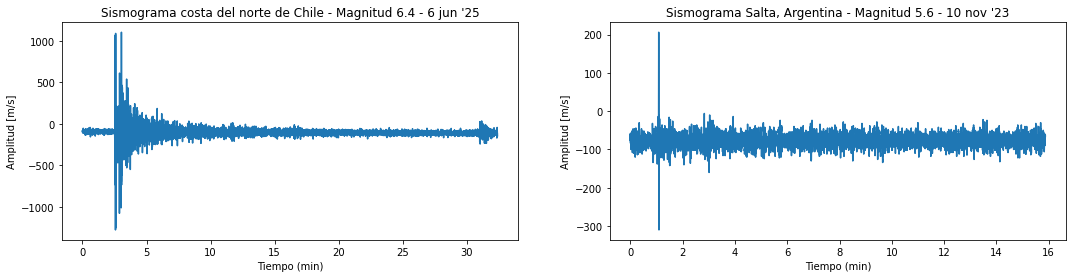

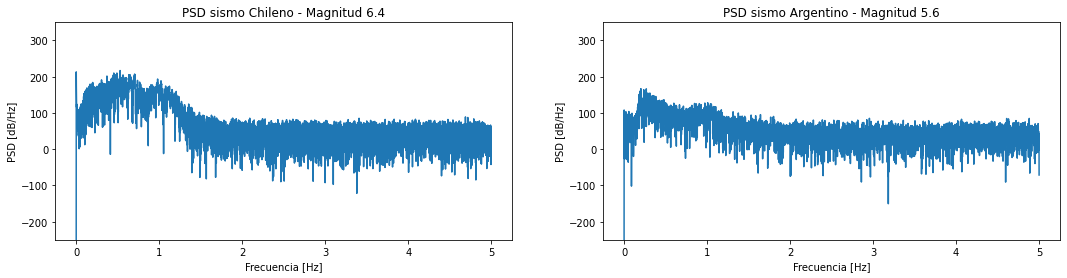

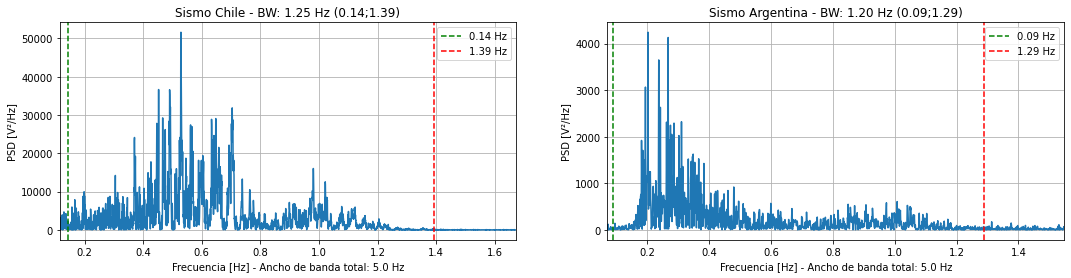

In [101]:
### GRAFICOS ###

## Datos generales ##
print(st_chi)
print(st_arg)

##  GRAFICO TEMPORAL ##
plt.figure(figsize=(18, 4))
plt.subplot(1,2,1); plt.plot(tiempo_chi/60, datos_chi)
plt.xlabel("Tiempo (min)"); plt.ylabel("Amplitud [m/s]");plt.title("Sismograma costa del norte de Chile - Magnitud 6.4 - 6 jun '25")
plt.subplot(1,2,2); plt.plot(tiempo_arg/60, datos_arg)
plt.xlabel("Tiempo (min)"); plt.ylabel("Amplitud [m/s]");plt.title("Sismograma Salta, Argentina - Magnitud 5.6 - 10 nov '23")
plt.show()

## DENSIDAD ESPECTRAL DE POTENCIA ##
plt.figure(figsize=(18, 4))
plt.subplot(1,2,1); plt.plot(ff_chi, psd_chi_dB); plt.ylim(-250,350)
plt.title("PSD sismo Chileno - Magnitud 6.4")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.subplot(1,2,2); plt.plot(ff_arg, psd_arg_dB); plt.ylim(-250,350)
plt.title("PSD sismo Argentino - Magnitud 5.6")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB/Hz]")
plt.show()

## ESTIMACION ANCHO DE BANDA ##
plt.figure(figsize=(18, 4))

plt.subplot(1,2,1); plt.plot(ff_chi, psd_chi); plt.xlim(lim_izq_chi*0.8, lim_der_chi*1.2)
plt.axvline(x=lim_izq_chi, color='green', linestyle='--', label=f'{lim_izq_chi:.2f} Hz')
plt.axvline(x=lim_der_chi, color='red', linestyle='--', label=f'{lim_der_chi:.2f} Hz')
plt.title(f"Sismo Chile - BW: {lim_der_chi-lim_izq_chi:.2f} Hz ({lim_izq_chi:.2f};{lim_der_chi:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_chi[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.subplot(1,2,2); plt.plot(ff_arg, psd_arg); plt.xlim(lim_izq_arg*0.8, lim_der_arg*1.2)
plt.axvline(x=lim_izq_arg, color='green', linestyle='--', label=f'{lim_izq_arg:.2f} Hz')
plt.axvline(x=lim_der_arg, color='red', linestyle='--', label=f'{lim_der_arg:.2f} Hz')
plt.title(f"Sismo Argentina - BW: {lim_der_arg-lim_izq_arg:.2f} Hz ({lim_izq_arg:.2f};{lim_der_arg:.2f})")
plt.xlabel(f"Frecuencia [Hz] - Ancho de banda total: {np.round(ff_arg[-1])} Hz"); plt.ylabel("PSD [V²/Hz]"); plt.grid(True); plt.legend()

plt.show()

### Análisis: Sismograma

Se aprecia como la señal del sismo registrado en Chile es mucho mas clara, con menor ruido. Para esta se determino incluir el 97% de la potencia total. En cambio, en la señal del sismo Argentino se tuvo que limitar al 85% de la potencia por el alto nivel del ruido blanco.

Ambas señales fueron tomadas por la misma estacion sismologica, y hasta donde es comunicado las mediciones puedo realizadas con el mismo equipo, por lo que la diferencia de ruido puede que venga de la distancia del equipo al epicentro del sismo o por la diferencia en magnitud de estos, presentando lecturas mas claras ante mayor magnitud.

Los anchos de banda obtenidos corresponden con lo esperado, siendo que para pequeños y moderados sismos las frecuencias dominantes se encuentran entre los 0.1 a 1 Hz

### Estimacion de magnitudes

Calcular las magnitudes exactar a partir del sismograma es complejo, requiriendo de un analisis con estimaciones y suposiciones basadas en conocimiento que carezco o no tengo acceso, como la calibracion del intrumental. Por lo que no vamos a obtener los valores exactos, si no la diferencia entre ambos, para lo cual solo necesitamos conocer la energia sismica, la cual es proporcional al cuadrado de sus amplitudes. Es decir, la podemos obtener calculando el area debajo de la curva del PSD.

Luego, para obtener la diferencia entre ambas magnitudes utilizamos la ecuacion

$$ log(E) = 1,5.M + K$$

El analisis se complejizaria al momento de obtener la constante K, pero como solo buscamos la diferencia entre magnitudes esta se cancela.

$$\Delta M = ( log(E_{Chile}) - log(E_{Argentina}) ) / 1,5$$

In [102]:
energia_chi = np.trapz(psd_chi, ff_chi)
energia_arg = np.trapz(psd_arg, ff_arg)

print(f"Energia sismo chileno = {energia_chi:.2f} - Energia sismo Argentino {energia_arg:.2f}")

delta_Mw = (np.log10(energia_chi) - np.log10(energia_arg)) / 1.5
deltaReal = 6.4 - 5.6 # Magnitudes reales establecidas por la estacion sismografica

print(f"Delta real = {deltaReal:.2} - Delta calculado {delta_Mw:.2}")

Energia sismo chileno = 4833.68 - Energia sismo Argentino 321.02
Delta real = 0.8 - Delta calculado 0.79


Fuente:
- https://www.britannica.com/science/earthquake-geology/Properties-of-seismic-waves
- https://resnom.cicese.mx/sitio/images/Richter.pdf